In [2]:
#text classification: Movie Reviews using tensorflow, keras. Help from @tensorflow.org and keras.io 
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow import keras

!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0-dev20200218


In [4]:
#download IMDB datase
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

In [5]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
#test encoder to use any string
sample_string = 'Hello NLP with TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 8007, 8005, 3924, 22, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello NLP with TensorFlow."


In [7]:
#encoded representation
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
8007 ----> N
8005 ----> L
3924 ----> P 
22 ----> with 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Explore the Data:
Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [8]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [9]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Prepare the Data for Tranning: All reviews are different lengths,use padded_batch(padding is dynamic) to zero pad the sequences while batching.

In [10]:
buffer_size = 1000
train_batches = (train_data.shuffle(buffer_size).padded_batch(32))
test_batches = (test_data.padded_batch(32))

In [11]:
#each batch will have a shape of (batch_size, sequence_length) 
for example_batch, label_batch in train_batches.take(3):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (32, 1432)
label shape: (32,)
Batch shape: (32, 768)
label shape: (32,)
Batch shape: (32, 1109)
label shape: (32,)


Build the model: to use keras Sequential model(KNF model) API,the Sequential model API is great for deep learning model.

In [12]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()
#Keras offers an Embedding layer,requires input data be integer be encoded
#Pooling layer, Global average pooling operation for temporal data
#dense layer has an output shape of (batch_size,units),  just a regular layer of neurons in a neural network 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 21s 27ms/step - loss: 0.6828 - accuracy: 0.5009 - val_loss: 0.6662 - val_accuracy: 0.5083
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.6202 - accuracy: 0.5552 - val_loss: 0.5938 - val_accuracy: 0.5875
Epoch 3/10
782/782 [==============================] - 19s 24ms/step - loss: 0.5398 - accuracy: 0.6672 - val_loss: 0.5308 - val_accuracy: 0.6885
Epoch 4/10
782/782 [==============================] - 20s 25ms/step - loss: 0.4722 - accuracy: 0.7517 - val_loss: 0.4821 - val_accuracy: 0.7448
Epoch 5/10
782/782 [==============================] - 21s 27ms/step - loss: 0.4202 - accuracy: 0.8027 - val_loss: 0.4444 - val_accuracy: 0.7990
Epoch 6/10
782/782 [==============================] - 20s 25ms/step - loss: 0.3792 - accuracy: 0.8326 - val_loss: 0.4164 - val_accuracy: 0.8292
Epoch 7/10
782/782 [==============================] - 19s 24ms/step - loss: 0.3491 - accuracy: 0.8538 - val_loss: 0.3970 - val_accuracy:

In [15]:
loss, accuracy = model.evaluate(test_batches)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 14s 18ms/step - loss: 0.3315 - accuracy: 0.8589Loss:  0.33154324961402226
Accuracy:  0.85892


Create a graph of accuracy and loss over time

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

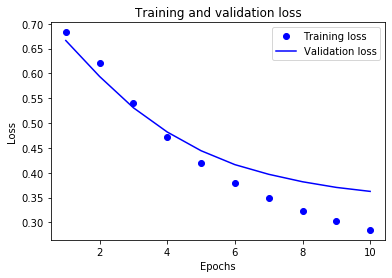

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

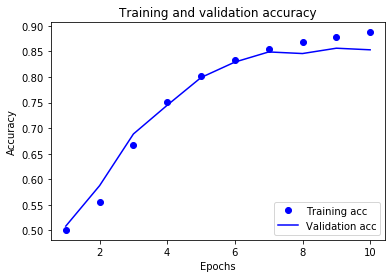

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()